In [34]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('../../')

import os
import yaml
import asyncio
import time
import statistics
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

from langchain_community.llms.sambanova import SambaStudio, Sambaverse
from transformers import AutoTokenizer
from utils.sambanova_endpoint import SambaNovaEndpoint

import replicate

from dotenv import load_dotenv
load_dotenv('../.env', override=True)

True

# Performance evaluation

In [35]:
# # Load Llama2 70b tokenizer
# access_token = os.getenv("HUGGINGFACE_TOKEN")
# tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-70b-chat-hf", token=access_token)

# # Load Llama2 13b tokenizer
# access_token = os.getenv("HUGGINGFACE_TOKEN")
# tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-13b-chat-hf", token=access_token)

# Load Llam2 7b tokenizer
access_token = os.getenv("HUGGINGFACE_TOKEN")
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf", token=access_token)

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [10]:
def get_snovautils_llm(max_tokens_to_generate):
    temperature = 0.01
    do_sample = False
    llm = SambaNovaEndpoint(
        base_url=os.getenv('SAMBASTUDIO_BASE_URL'),
        project_id=os.getenv('SAMBASTUDIO_PROJECT_ID'),
        endpoint_id=os.getenv('SAMBASTUDIO_ENDPOINT_ID'),
        api_key=os.getenv('SAMBASTUDIO_API_KEY'),
        model_kwargs={
            "do_sample": do_sample,
            "temperature": temperature,
            "max_tokens_to_generate": max_tokens_to_generate,
            #"stop_sequences": { "type":"str", "value":""},
            # "repetition_penalty": {"type": "float", "value": "1"},
            # "top_k": {"type": "int", "value": "50"},
            # "top_p": {"type": "float", "value": "1"}
        }
    )
    return llm

def get_snovastudio_llm(max_tokens_to_generate):
    temperature = 0.01
    do_sample = False
    llm = SambaStudio(
        model_kwargs={
            "do_sample": do_sample,
            "temperature": temperature,
            "max_tokens_to_generate": max_tokens_to_generate,
            #"stop_sequences": { "type":"str", "value":""},
            # "repetition_penalty": {"type": "float", "value": "1"},
            # "top_k": {"type": "int", "value": "50"},
            # "top_p": {"type": "float", "value": "1"}
        }
    )
    return llm

# Mistral - Sambaverse
def get_snovaverse_llm(max_tokens_to_generate):
    temperature = 0.01
    do_sample = False
    sverse_llm = Sambaverse(
        sambaverse_model_name="Mistral/Mistral-7B-Instruct-v0.2",
        model_kwargs={
            'do_sample': do_sample, 
            'temperature': temperature,
            'max_tokens_to_generate': max_tokens_to_generate,
            'select_expert': "Mistral-7B-Instruct-v0.2",
            'process_prompt': True
        }
    )
    return sverse_llm

# Llama 7b - Replicate
class ReplicateWrapper():
    def __init__(self, max_tokens_to_generate):
        self.api = replicate.Client(api_token=os.getenv('REPLICATE_API_TOKEN'))
        self.temperature = 0.1
        self.max_length = max_tokens_to_generate
    def invoke(self, prompt):
        input = {
            "prompt": prompt,
            "temperature": self.temperature,
            "max_length": self.max_length
        }

        output = self.api.run(
            "replicate/llama-7b:455d66312a66299fba685548fe24f66880f093007b927abd19f4356295f8577c",
            input=input
        )
        
        return "".join(output) 
        
def get_replicate_llm(max_tokens_to_generate):
    replicate_llm = ReplicateWrapper(max_tokens_to_generate)
    return replicate_llm


In [11]:
def get_out_tokens(generated_string):
  encoded = tokenizer(generated_string)
  return len(encoded['input_ids'])

In [12]:
def get_artificial_prompt(input_tokens):
    template = 'I will repeat this sentence many times for testing. '
    template_encoded = tokenizer(template)
    groups = int(input_tokens / (len(template_encoded['input_ids'])-1))
    
    artificial_prompt = [template*(groups)]
    prompt_encoded = tokenizer(artificial_prompt[0])
    artificial_input_tokens = len(prompt_encoded['input_ids'])
    
    return artificial_prompt[0], artificial_input_tokens

In [18]:
latencies = []

# This is a single worker, which processes the given number of requests, one after the other.
async def worker(index, num_requests, in_tokens=2048, max_out_tokens=256):
  print(f"Processing concurrent worker {index}")
  prompt, artificial_in_tokens = get_artificial_prompt(in_tokens)
  llm = get_snovastudio_llm(max_out_tokens)
  # Sleep some time to offset the threads.
  await asyncio.sleep(0.01*index)
  
  for _ in tqdm(range(num_requests)):
    request_start_time = time.time()
    generated_ouput = llm.invoke(prompt[0])
    latency = time.time() - request_start_time
    out_tokens = get_out_tokens(generated_ouput)
    latencies.append((artificial_in_tokens, out_tokens, latency))
    
async def dummy_worker(index, num_requests, in_tokens=2048, max_out_tokens=256):
  asyncio.sleep(0.01*index)
  for _ in tqdm(range(num_requests)):
    latency = random.randint(0,9)*index
    latencies.append((in_tokens, max_out_tokens, latency))

In [14]:
# This code runs parallel_requests's parallel sets of queries with num_requests_per_worker queries per worker.
async def single_benchmark(num_requests_per_worker, num_workers, in_tokens=2048, out_tokens=256):
  tasks = []
  for i in range(num_workers):
    # run worker in background
    # task = asyncio.create_task(worker(i, num_requests_per_worker, in_tokens, out_tokens))
    task = asyncio.create_task(worker(i, num_requests_per_worker, in_tokens, out_tokens))
    tasks.append(task)
  # gather results from concurrent workers 
  await asyncio.gather(*tasks)

In [28]:
# This runs the benchmark with 1, n/2 and n output tokens to enable deriving time to first token (from 1 output token)
# and the time per token by looking at the difference in latency between 64 and 128 output tokens.
async def benchmark(parallel_workers=1, in_tokens=2048, out_tokens=256, num_requests_per_worker=5):
  # store statistics about the number of input/outpu and the latency for each setup.
  avg_num_input_tokens = [0, 0, 0]
  avg_num_output_tokens = [0, 0, 0]
  median_latency = [0, 0, 0]
  
  print(f"Parallel queries {parallel_workers}")
  for i, out_tokens in enumerate([1, out_tokens/2, out_tokens]):
    
    # Clear the latencies array so that we get fresh statistics.
    latencies.clear()
    await single_benchmark(num_requests_per_worker, parallel_workers, in_tokens, out_tokens)
    
    # Compute the median latency and the mean number of tokens.
    avg_num_input_tokens[i] = statistics.mean([inp for inp, _, _ in latencies])
    avg_num_output_tokens[i] = statistics.mean([outp for _, outp, _ in latencies])
    median_latency[i] = statistics.median([latency for _, _, latency in latencies])
    
    tokens_per_sec = (avg_num_input_tokens[i]+avg_num_output_tokens[i])*parallel_workers/median_latency[i]
    print(f'Output tokens {avg_num_output_tokens[i]}, median latency (s): {round(median_latency[i], 2)}, tokens per second {round(tokens_per_sec, 1)}')
  
  # We use difference in the time between out_tokens/2 and out_tokens to generate find the time per output token
  # these are stored in median_latency[1] and median_latency[2] respectively
  # We use the time to generate just 1 token to get the time to first token, this is stored in median_latency[0]
  output_token_time = (median_latency[2] - median_latency[1])*1000/(avg_num_output_tokens[2]-avg_num_output_tokens[1])
  print(f'Time to first token (s): {round(median_latency[0],2)}, Time per output token (ms) {round(output_token_time,2)}')

  output = {
    'parallel_workers': parallel_workers,
    'performance_metrics': {
      'TTFT': round(median_latency[0],2),
      'TPOT': output_token_time,
      'latency': median_latency[2],
      'throughput': (avg_num_input_tokens[2]+avg_num_output_tokens[2])*parallel_workers/median_latency[2]
    }
  }
  data.append(output)

## Run benchmarking

## Example with Llama2 70B SambaStudio

In [ ]:
# Number of input and outut tokens to benchmark
input_tokens = 2048
output_tokens = 256
# Number of requests per worker(thread), higher gives more accurate results
num_requests_per_worker = 20

In [ ]:
# This will run until the throughput of the model is no longer increasing by 10%.
data = []
for parallel_workers in [1, 2, 4, 8]:
  print(f"Number of ideal input tokens {input_tokens}")
  await benchmark(parallel_workers, input_tokens, output_tokens, num_requests_per_worker)
  # Break if the throughput doesn't increase by more than 10%
  if len(data) > 1 and (data[-1]['throughput'] - data[-2]['throughput'])/data[-2]['throughput'] < 0.1:
    break

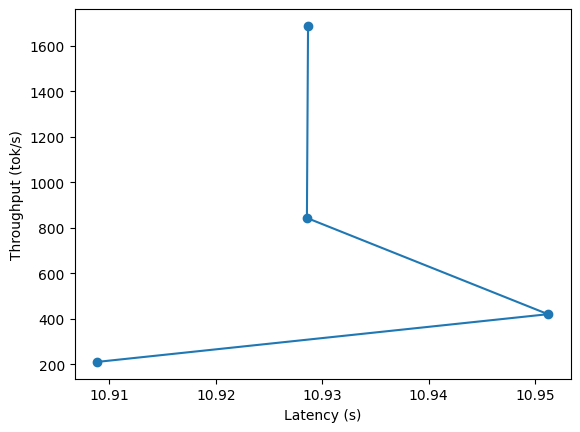

In [ ]:
# Plot the latency vs throughput curve
plt.xlabel("Latency (s)")
plt.ylabel("Throughput (tok/s)")
line = plt.plot([x['latency'] for x in data], [x['throughput'] for x in data], marker='o')
plt.show()

## Example using Mistral from Sambaverse - Hit max tries

In [123]:
# Number of input and outut tokens to benchmark
input_tokens = 50
output_tokens = 50
# Number of requests per worker(thread), higher gives more accurate results
num_requests_per_worker = 20

In [124]:
# This will run until the throughput of the model is no longer increasing by 10%.
data = []

for parallel_workers in [1, 2, 4, 8]:
  print(f"Number of ideal input tokens {input_tokens}")
  await benchmark(parallel_workers, input_tokens, output_tokens, num_requests_per_worker)
  # Break if the throughput doesn't increase by more than 10%
  if len(data) > 1 and (data[-1]['throughput'] - data[-2]['throughput'])/data[-2]['throughput'] < 0.1:
    break

Number of ideal input tokens 50
Parallel queries 1
Processing concurrent worker 0


100%|██████████| 20/20 [00:30<00:00,  1.51s/it]


Output tokens 2, median latency (s): 1.09, tokens per second 40.5
Processing concurrent worker 0


 50%|█████     | 10/20 [00:11<00:11,  1.19s/it]

{'detail': 'Expecting value: line 1 column 1 (char 0)', 'status_code': 429}


ValueError: Error raised by the inference endpoint: 'details'

## Example trying Replicate

In [116]:
# Number of input and outut tokens to benchmark
input_tokens = 50
output_tokens = 50
# Number of requests per worker(thread), higher gives more accurate results
num_requests_per_worker = 25

In [117]:
# This will run until the throughput of the model is no longer increasing by 10%.
data = []
for parallel_workers in [1, 2, 4]:
  print(f"Number of ideal input tokens {input_tokens}")
  await benchmark(parallel_workers, input_tokens, output_tokens, num_requests_per_worker)
  # Break if the throughput doesn't increase by more than 10%
  if len(data) > 1 and (data[-1]['throughput'] - data[-2]['throughput'])/data[-2]['throughput'] < 0.1:
    break

Number of ideal input tokens 50
Parallel queries 1
Processing concurrent worker 0


100%|██████████| 25/25 [02:02<00:00,  4.91s/it]


Output tokens 2, median latency (s): 0.96, tokens per second 45.7
Processing concurrent worker 0


100%|██████████| 25/25 [00:41<00:00,  1.67s/it]


Output tokens 24, median latency (s): 1.64, tokens per second 40.3
Processing concurrent worker 0


 64%|██████▍   | 16/25 [00:37<00:21,  2.36s/it]


ReplicateError: You have reached the free time limit. To continue using Replicate, set up billing at https://replicate.com/account/billing#billing.

## Example trying Llama2 7b

In [30]:
# Number of input and outut tokens to benchmark
input_tokens = 50
output_tokens = 50
# Number of requests per worker(thread), higher gives more accurate results
num_requests_per_worker = 5

In [31]:
# This will run until the throughput of the model is no longer increasing by 10%.
data = []
for parallel_workers in [1, 2, 4, 8]:
  print(f"Number of ideal input tokens {input_tokens}")
  await benchmark(parallel_workers, input_tokens, output_tokens, num_requests_per_worker)
  # Break if the throughput doesn't increase by more than 10%
  if len(data) > 1 and (data[-1]['performance_metrics']['throughput'] - data[-2]['performance_metrics']['throughput'])/data[-2]['performance_metrics']['throughput'] < 0.1:
    break

Number of ideal input tokens 50
Parallel queries 1
Processing concurrent worker 0


100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Output tokens 2, median latency (s): 2.15, tokens per second 20.5
Processing concurrent worker 0


100%|██████████| 5/5 [00:14<00:00,  2.93s/it]


Output tokens 26, median latency (s): 2.93, tokens per second 23.2
Processing concurrent worker 0


100%|██████████| 5/5 [00:18<00:00,  3.76s/it]


Output tokens 51, median latency (s): 3.76, tokens per second 24.7
Time to first token (s): 2.15, Time per output token (ms) 33.42
Number of ideal input tokens 50
Parallel queries 2
Processing concurrent worker 0
Processing concurrent worker 1


100%|██████████| 5/5 [00:10<00:00,  2.20s/it]


Output tokens 2, median latency (s): 2.18, tokens per second 40.3
Processing concurrent worker 0
Processing concurrent worker 1


100%|██████████| 5/5 [00:14<00:00,  2.94s/it]


Output tokens 26, median latency (s): 2.94, tokens per second 46.2
Processing concurrent worker 0
Processing concurrent worker 1


100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Output tokens 51, median latency (s): 3.73, tokens per second 49.9
Time to first token (s): 2.18, Time per output token (ms) 31.46
Number of ideal input tokens 50
Parallel queries 4
Processing concurrent worker 0
Processing concurrent worker 1
Processing concurrent worker 2
Processing concurrent worker 3


100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Output tokens 2, median latency (s): 2.18, tokens per second 80.6
Processing concurrent worker 0
Processing concurrent worker 1
Processing concurrent worker 2
Processing concurrent worker 3


100%|██████████| 5/5 [00:14<00:00,  2.94s/it]


Output tokens 26, median latency (s): 2.93, tokens per second 93.0
Processing concurrent worker 0
Processing concurrent worker 1
Processing concurrent worker 2
Processing concurrent worker 3


100%|██████████| 5/5 [00:18<00:00,  3.76s/it]


Output tokens 51, median latency (s): 3.74, tokens per second 99.4
Time to first token (s): 2.18, Time per output token (ms) 32.74
Number of ideal input tokens 50
Parallel queries 8
Processing concurrent worker 0
Processing concurrent worker 1
Processing concurrent worker 2
Processing concurrent worker 3
Processing concurrent worker 4
Processing concurrent worker 5
Processing concurrent worker 6
Processing concurrent worker 7


100%|██████████| 5/5 [00:10<00:00,  2.20s/it]


Output tokens 2, median latency (s): 2.19, tokens per second 160.7
Processing concurrent worker 0
Processing concurrent worker 1
Processing concurrent worker 2
Processing concurrent worker 3
Processing concurrent worker 4
Processing concurrent worker 5
Processing concurrent worker 6
Processing concurrent worker 7


100%|██████████| 5/5 [00:14<00:00,  2.96s/it]


Output tokens 26, median latency (s): 2.95, tokens per second 184.4
Processing concurrent worker 0
Processing concurrent worker 1
Processing concurrent worker 2
Processing concurrent worker 3
Processing concurrent worker 4
Processing concurrent worker 5
Processing concurrent worker 6
Processing concurrent worker 7


100%|██████████| 5/5 [00:18<00:00,  3.74s/it]

Output tokens 51, median latency (s): 3.74, tokens per second 198.7
Time to first token (s): 2.19, Time per output token (ms) 31.78


In [32]:
data

[{'parallel_workers': 1,
  'performance_metrics': {'TTFT': 2.15,
   'TPOT': 33.42292785644531,
   'latency': 3.761892080307007,
   'throughput': 24.721602325287943}},
 {'parallel_workers': 2,
  'performance_metrics': {'TTFT': 2.18,
   'TPOT': 31.45519256591797,
   'latency': 3.7270323038101196,
   'throughput': 49.905658131767055}},
 {'parallel_workers': 4,
  'performance_metrics': {'TTFT': 2.18,
   'TPOT': 32.73581504821777,
   'latency': 3.743805408477783,
   'throughput': 99.36413873370992}},
 {'parallel_workers': 8,
  'performance_metrics': {'TTFT': 2.19,
   'TPOT': 31.779398918151855,
   'latency': 3.744665026664734,
   'throughput': 198.68265778171875}}]

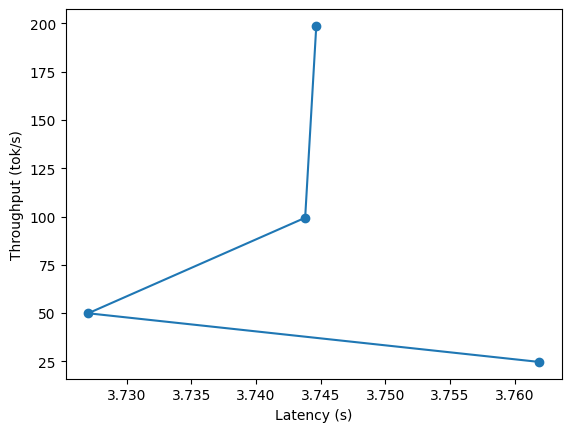

In [33]:
# Plot the latency vs throughput curve
plt.xlabel("Latency (s)")
plt.ylabel("Throughput (tok/s)")
# line = plt.plot([x['latency'] for x in data], [x['throughput'] for x in data], marker='o')
line = plt.plot([x['performance_metrics']['latency'] for x in data], [x['performance_metrics']['throughput'] for x in data], marker='o')
plt.show()

In [ ]:
# Post from Andrew Ng
# Today, a lot of LLM output is for human consumption. A human might read around 250 words per minute, which is around 6 tokens per second 
# (250 words/min / (0.75 words/token) / (60 secs/min)). So it might seem there’s little value to generating tokens much faster than this.